# Test criterions for Benchmark

In [73]:
# FUNCTIONS / CLASSES :
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
sys.path.append("./code")
from criterions import compute_correlation, domain_coverage, bad_quality_detection, Borda_count

metrics = [METEOR, BLEU, NIST, WACC]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
data = pd.read_csv("./data/metrics_scores.csv")

In [40]:
str(metrics[1].__name__)

'BLEU'

In [41]:
compute_correlation(
    data = data,
    metric_1 = str(metrics[1].__name__),
    metric_2 = str(metrics[2].__name__),
    correlation_type = "spearman"
)

0.7655464881918864

In [42]:
data = pd.read_csv("./data/metrics_scores.csv")
data = data[data.sltl == "ende"]

print("Correlation w human score : ")
for metric in metrics:
    metric_name = str(metric.__name__)
    print("METRIC NAME : ", metric_name)
    for domain in data.domain.unique():
        score = domain_coverage(
                    data = data,
                    candidate_metric = metric_name,
                    correlation_type = "spearman",
                    domain = domain
                )
        print(domain.upper(), " => ", score)
    
    print("\n")

Correlation w human score : 
METRIC NAME :  METEOR
CONVERSATION  =>  0.29232146594181735
NEWS  =>  0.14755862329587788
ECOMMERCE  =>  0.1428198816575085
SOCIAL  =>  0.13670858233137786


METRIC NAME :  BLEU
CONVERSATION  =>  0.2690547729282605
NEWS  =>  0.13753846033647954
ECOMMERCE  =>  0.1474266728613931
SOCIAL  =>  0.13686813474759743


METRIC NAME :  NIST
CONVERSATION  =>  0.136395603558826
NEWS  =>  0.06457183567530851
ECOMMERCE  =>  0.09723806320788869
SOCIAL  =>  0.04130344874851459


METRIC NAME :  WACC
CONVERSATION  =>  0.2571734166783578
NEWS  =>  0.14278561240372054
ECOMMERCE  =>  0.13728413921002927
SOCIAL  =>  0.1302596016046559




In [45]:
data = pd.read_csv("./data/metrics_scores.csv")
data = data[data.sltl == "ende"]

print("Correlation w human score : ")
for metric in metrics:
    metric_name = str(metric.__name__)
    print("METRIC NAME : ", metric_name)
    score = bad_quality_detection(
                data = data,
                candidate_metric = metric_name,
                correlation_type = "spearman",
                alpha = 0.1
            )
    print("SCORE => ", score)
    print("\n")

Correlation w human score : 
METRIC NAME :  METEOR
SCORE =>  0.14359812566483127


METRIC NAME :  BLEU
SCORE =>  0.12923011554030808


METRIC NAME :  NIST
SCORE =>  0.06066513031706968


METRIC NAME :  WACC
SCORE =>  0.14434483529920777




BORDA COUNT RANKS : 
METEOR  :  0
BLEU  :  1
NIST  :  2
WACC  :  3


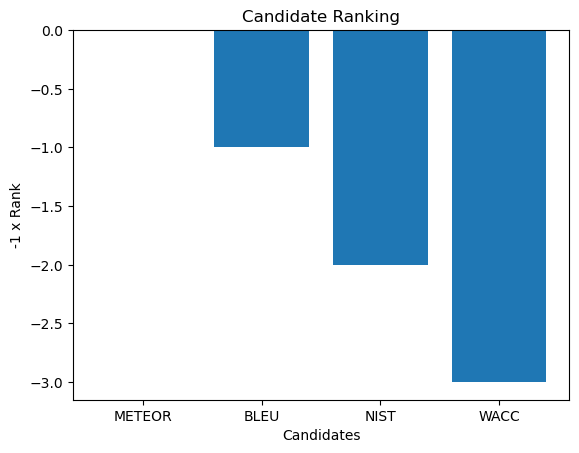

In [77]:
data = pd.read_csv("./data/metrics_scores.csv")
L = len(data.domain.unique())
N = len(metrics)
ranks = np.empty((L, N))

for l in range(L):
    criterion_scores = []
    criterion_domain = data.domain.unique()[l]
    for n in range(N):
        candidate_metric = str(metrics[n].__name__)
        score = domain_coverage(
                    data = data,
                    candidate_metric = candidate_metric,
                    correlation_type = "spearman",
                    domain = criterion_domain
                )
        criterion_scores.append(-1*score)
    
    ranks[l,:] = np.argsort(criterion_scores)

borda_count_ranks = Borda_count(ranks)
print("BORDA COUNT RANKS : ")
for n in range(N):
    print(str(metrics[n].__name__) , " : ", borda_count_ranks[n])

plt.bar([str(metric.__name__) for metric in metrics], -1*borda_count_ranks)
plt.xlabel('Candidates')
plt.ylabel('-1 x Rank')
plt.title('Candidate Ranking')
plt.show()